## Imports

In [33]:
import matplotlib.pyplot as plt

import shapely.geometry as geom
import shapely.affinity as aff

import math

import collections.abc

import geopandas as gpd

import time

# Global Functions

## Plotting geometries

In [34]:
def plotCoords(coords, axes):
    x,y = zip(*list(coords))
    axes.plot(x,y)

def plotPoints(points, axes):
    x,y = zip(*list(points))
    axes.scatter(x, y)

def plotPolys(polys, axes):
    for poly in polys:
        if not getattr(poly, "exterior", None):
            print("got line?")

        plotCoords(poly.exterior.coords, axes)

        for hole in poly.interiors:
            plotCoords(hole.coords, axes)

## Recursively rounding every number in an iterable

In [35]:
def recursiveRound(iter, digits):
    if isinstance(iter, collections.abc.Iterable) == False:
        try: # if it is a number, round it
            return round(iter, digits)
        except:
            return iter
    else: # assign child objects (iter) to current object
        for index, value in enumerate(iter):
            recursed = recursiveRound(value, digits)
            try: # when iter isn't a tuple
                iter[index] = recursed
            except(TypeError):
                iterCopy = list(iter)
                iterCopy[index] = recursed
                iter = tuple(iterCopy)
        return iter

# print(recursiveRound([(0.292, 0.21722014), [(118.2194, 0.10282)]], 2))

## Generating a regular polygon

In [36]:
def makePoly(sides, radius):
    line = geom.LineString([(0, 0), (0, radius)])
    vertices = []

    if sides % 2 == 0:
        line = aff.rotate(line, -360 / sides / 2, origin=(0, 0))

    for i in range(0, sides):
        line = geom.LineString([*line.coords])
        vertices.append(line.coords[1])
        line = aff.rotate(line, -360 / sides, origin=(0, 0))

    return geom.Polygon(vertices)

## Finding the angle between three points

In [3]:
def cosRule(x, y, z):
    # a^2 = b^2 + c^2 − 2bccos(A)
    a = math.sqrt((y.y - z.y)**2 + (y.x - z.x)**2)
    b = x.distance(z)
    c = x.distance(y)

    return math.acos((b**2 + c**2 - a**2)/(2*b*c))

# angleFinder(geom.Point(0, 3), geom.Point(1, 2), geom.Point(3, -1))

def angleFinder(a, b, nextA, nextB):
    aAngle = (len(a.exterior.coords) - 3) * 180 / (len(a.exterior.coords) - 3)
    bAngle = (len(b.exterior.coords) - 3) * 180 / (len(b.exterior.coords) - 3)

    if touches(b, nextA[0]):
        nextA[1] = (nextA[1] + 1) % len(a.exterior.coords)
        if nextB[0].__eq__(nextA[0]):
            # on edge
            b = aff.rotate(b, 360 - aAngle - bAngle, origin=nextA[0])

            nextB[1] = (nextB[1] + 1) % len(b.exterior.coords)
            nextB[0] = extractPoint(nextB[1], b)
        else:
            # over edge
            b = aff.rotate(b, 180 - aAngle, origin=nextA[0])

            nextB[1] = (nextB[1] + 1) % len(b.exterior.coords)
            nextB[0] = extractPoint(nextB[1], b)
        nextA[0] = extractPoint(nextA[1], a)
    else:
        # behind edge
        b = aff.rotate(b, 180 - bAngle, origin=nextA[0])

        nextA[1] = (nextA[1] + 1) % len(a.exterior.coords)
        nextB[1] = (nextB[1] + 1) % len(b.exterior.coords)

        nextA[0] = extractPoint(nextA[1], a)
        nextB[0] = extractPoint(nextB[1], b)

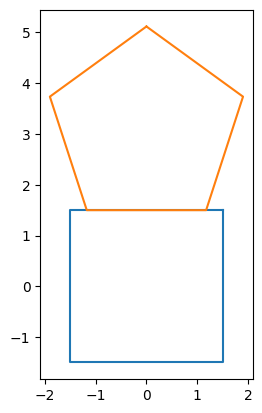 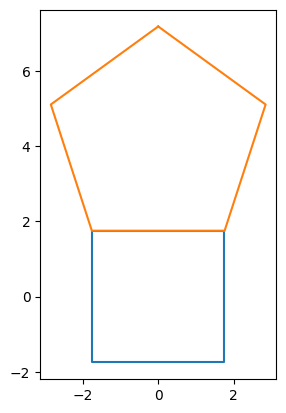 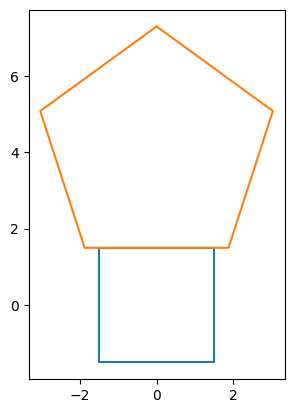 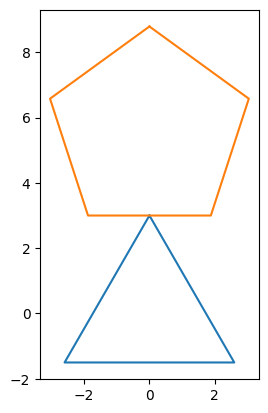

In [2]:
def touches(a, b):
    return geom.LineString(a.exterior.coords).distance(b) < 0.00000000001

def extractPoint(index, poly):
    return geom.Point(poly.exterior.coords[index])

# Testing

In [1]:
a = makePoly(3, 1)
b = makePoly(4, 1)

b = aff.translate(b, yoff=abs(a.bounds[3]) + abs(b.bounds[1]))

SyntaxError: invalid syntax (1028020879.py, line 14)

True


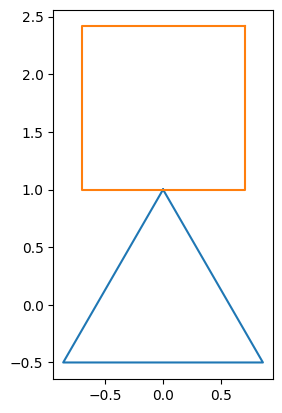

In [69]:
print(touches(b, geom.Point(a.exterior.coords[0])))

fig, axes = plt.subplots(1, 1)
plotPolys([a, b], axes)
axes.axes.set_aspect("equal")